# Some Typical Financial Calculations

# Load Packages

The Roots and Distributions packages have been used in the previous notebooks, but StatsBase not. It contains methods for estimating means, variances, ranks, correlations etc. See https://github.com/JuliaStats/StatsBase.jl. 

In [1]:
using StatsBase, Roots, Distributions

using Compat, Missings            #in Julia 0.6 
#using Dates, DelimitedFiles      #in Julia 0.7

include("printmat.jl")            #function for prettier matrix printing

printlnPs (generic function with 2 methods)

In [2]:
using Plots

backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(600,400))
end

Plots.GRBackend()

# CAPM and Return Autocorrelation

The CAPM regression is

$R_{it}^{e}  =\alpha_{i}+\beta_{i}R_{mt}^{e}+\varepsilon_{it}$,

where $R_{mt}^{e}$ is the market excess return. Theory says that $\alpha=0$, which is easily tested.

### Load Data

In [3]:
x   = readdlm("Data/MyData.csv",',',skipstart=1)        #monthly return data
ym  = round.(Int,x[:,1])     #yearmonth, like 200712
Rme = x[:,2]                 #market excess return
Rf  = x[:,3]                 #interest rate
R   = x[:,4]                 #return small growth stocks
Re  = R - Rf                 #excess returns
T   = size(Rme,1)

dN = Date.(string.(ym),"yyyymm")  #convert to string and then Julia Date
printmat(dN[1:4])

1979-01-01
1979-02-01
1979-03-01
1979-04-01



### CAPM Regression

In [4]:
x    = [ones(T) Rme]             #regressors
y    = copy(Re)                  #to get standard OLS notation
b    = x\y                       #OLS
u    = y - x*b                   #residuals
covb = inv(x'x)*var(u)           #cov(b), see any textbook
stdb = sqrt.(diag(covb))         #std(b)
R2a  = 1 - var(u)/var(y)

println("     coeff      std     t-stat")
printmat([b stdb b./stdb])
printlnPs("R2: ",R2a)
printlnPs("no. of observations: ",T)

     coeff      std     t-stat
    -0.504     0.304    -1.656
     1.341     0.066    20.427

R2:      0.519
no. of observations:        388


## Return Autocorrelation

That is, the correlation of $R_{t}^{e}$ and $R_{t-s}^{e}$. 

It can be shown that the t-stat of an autocorrelation is $\sqrt{T}$ times the autocorrelation.

In [5]:
plags = 1:5
xCorr = autocor(Re,plags)         #using the StatsBase package

println("Autocorrelations of the excess returns in Re")
println("\n     lag   autocorrr    t-stat")
printmat([plags xCorr sqrt(T)*xCorr])

Autocorrelations of the excess returns in Re

     lag   autocorrr    t-stat
     1.000     0.216     4.253
     2.000     0.002     0.046
     3.000    -0.018    -0.359
     4.000    -0.065    -1.289
     5.000    -0.027    -0.536



# A Trading Strategy

The next cell implements a very simple (momentum) trading strategy: if $R_{t-1}^{e}\ge0$, then we hold the market index and shorten the riskfree from $t-1$ to $t$. Instead,  if $R_{t-1}^{e}<0$, then we do the opposite.

This simple strategy could be coded without using a loop, but "vectorization" does not speed up much. 

In [6]:
w  = fill(NaN,T)
Rp = fill(NaN,T)
for t = 2:T
  w[t]  = (Re[t-1] < 0)*(-1) + (Re[t-1] >= 0)*1       #w is -1 or 1
  Rp[t] = w[t]*Re[t] 
end

μ = [mean(Rp[2:end]) mean(Re[2:end])]
σ = [std(Rp[2:end])  std(Re[2:end])]

printlnPs("The annualized mean excess return of the strategy and a passive portfolio are: ",μ*12)
printlnPs("The annualized Sharpe ratios are: ",sqrt(12)*μ./σ)

The annualized mean excess return of the strategy and a passive portfolio are:     26.733     3.329
The annualized Sharpe ratios are:      0.932     0.112


# Value at Risk

The next cell first constructs an simple estimate of $\sigma_t^2$ as a backward looking moving average (the RiskMetrics approach)

$\sigma_t^2 = \lambda \sigma_{t-1}^2 + (1-\lambda) (R_{t-1} -\mu)^2$,
where $\mu$ is the average return (for all data).

Then, we calculate the 95% VaR by assuming a $N(\mu,\sigma_t^2)$ distribution

$\textrm{VaR}_{t} = - (\mu-1.64\sigma_t)$.

If the model is correct, then the loss should not exceed  the VaR ($-R_t > \text{VaR}_{t}$) in more than 5% of the months.

In [7]:
μ = mean(Rme)

λ = 0.95                         #weight on old volatility
σ² = fill(var(Rme),T)            #RiskMetrics approach to estimate variance     
for t = 2:T
  σ²[t] = λ*σ²[t-1] + (1-λ)*(Rme[t-1]-μ)^2    
end

VaR95 = -(μ .- 1.64*sqrt.(σ²))      #VaR at 95% level

println("let's plot it")

let's plot it


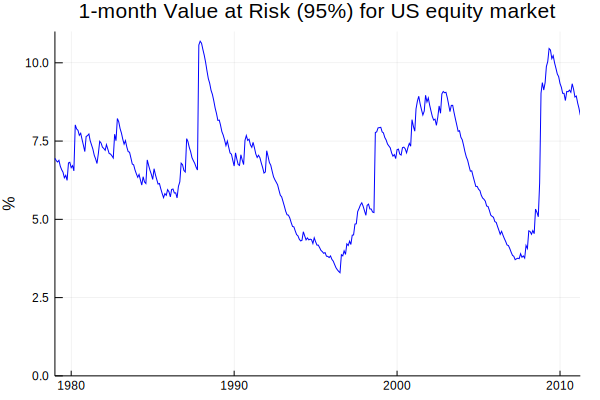

In [8]:
xTicksLoc = Dates.value.([Date(1980);Date(1990);Date(2000);Date(2010)])
xTicksLab = ["1980";"1990";"2000";"2010"]   #crude way of getting tick marks right

plot1 = plot(dN,VaR95,color=:blue,legend=false,xticks=(xTicksLoc,xTicksLab))
plot!(ylim=(0,11))
title!("1-month Value at Risk (95%) for US equity market")
ylabel!("%")

# Options

## Black-Scholes Option Price

Let $S$ be the the current spot price of an asset and $y$ be the interest rate.

The Black-Scholes formula for a European call option (on that asset) with strike price $K$ and time to expiration $m$ is

$C  =S\Phi(d_{1})  -e^{-ym}K\Phi(d_{2})$, where

$d_{1} =\frac{\ln(S/K)+(y+\sigma^{2}/2)m}{\sigma\sqrt{m}} \ \text{ and } \ d_{2}=d_{1}-\sigma\sqrt{m}$ 

and where $\Phi(d)$ denotes the probability of $x\leq d$ when $x$ has an $N(0,1)$ distribution. All variables except the volatility ($\sigma$) are directly observable. 

In [9]:
function Φ(x)
    #Calculates Pr(z<=x) for N(0,1) variable z
    Pr = cdf(Normal(0,1),x)         #Distributions package
  return Pr
end

function OptionBlackSPs(S,K,m,y,σ)
#Calculates Black-Scholes european call option price
  d1 = ( log(S/K) + (y+1/2*σ^2)*m ) / (σ*sqrt(m))
  d2 = d1 - σ*sqrt(m)
  c  = S*Φ(d1) - exp(-y*m)*K*Φ(d2)
  return c
end

OptionBlackSPs (generic function with 1 method)

In [10]:
σ = 0.4
c1 = OptionBlackSPs(10,10,0.5,0.1,σ)
printlnPs("\n","call price according to Black-Scholes: ",c1)

K = Compat.range(7,stop=13,length=51)   #0.7 syntax
c = OptionBlackSPs.(10,K,0.5,0.1,σ)

println("let's plot it")


call price according to Black-Scholes:      1.358
let's plot it


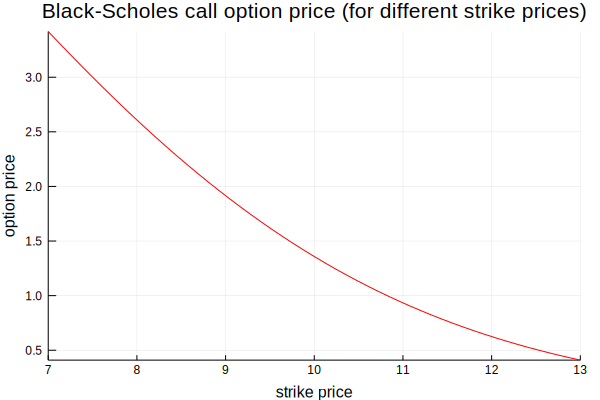

In [11]:
plot1 = plot(K,c,color=:red,legend=false)
title!("Black-Scholes call option price (for different strike prices)")
xlabel!("strike price")
ylabel!("option price")

# Implied Volatility

is the $\sigma$ value that makes the Black-Scholes equation give the same option price as observed on the market. It is often interpreted as the "market uncertainty."

The next cell uses the call option price calculated above as being the "market price." The implied volatility should then be the same as what we used to calculate that price (this is a way to check your calculations).

In [12]:
                                #simple (crude) way to solve for implied vol
iv = find_zero(σ->OptionBlackSPs(10,10,0.5,0.1,σ)-c1,(0.00001,5))

printlnPs("Implied volatility: ",iv,", compare with: $σ")

Implied volatility:      0.400, compare with: 0.4


The next few cells instead some data on options on German government bonds. 

In [13]:
#  LIFFE Bunds option data, trade date April 6, 1994
K = [                        #strike prices; Mx1 vector
      92.00;  94.00;  94.50;  95.00;  95.50;  96.00;  96.50;  97.00;
      97.50;  98.00;  98.50;  99.00;  99.50;  100.0;  100.5;  101.0;
     101.5;  102.0;  102.5;  103.0;  103.5 ];
C = [                        #call prices; Mx1 vector
      5.13;    3.25;    2.83;    2.40;    2.00;    1.64;    1.31;    1.02;
      0.770;   0.570;   0.400;   0.280;   0.190;   0.130;  0.0800;  0.0500;
      0.0400;  0.0300;  0.0200;  0.0100;  0.0100 ];
S = 97.05                #spot price
m = 48/365               #time to expiry in years
y = 0.0                  #Interest rate: LIFFE=>no discounting
N = length(K)

21

In [14]:
iv = fill(NaN,N)
for i = 1:N
  iv[i] = find_zero(sigma->OptionBlackSPs(S,K[i],m,y,sigma)-C[i],(0.00001,5))
end

println("Strike and iv for data: ")
printmat([K iv])

println("let's plot it")

Strike and iv for data: 
    92.000     0.094
    94.000     0.081
    94.500     0.081
    95.000     0.078
    95.500     0.075
    96.000     0.074
    96.500     0.072
    97.000     0.071
    97.500     0.070
    98.000     0.069
    98.500     0.068
    99.000     0.067
    99.500     0.067
   100.000     0.068
   100.500     0.067
   101.000     0.067
   101.500     0.070
   102.000     0.073
   102.500     0.074
   103.000     0.072
   103.500     0.077

let's plot it


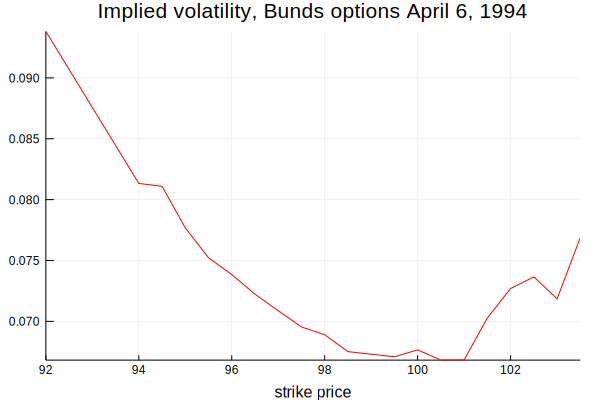

In [15]:
plot1 = plot(K,iv,color=:red,legend=false)
title!("Implied volatility, Bunds options April 6, 1994")
xlabel!("strike price")

# Mean-Variance Frontier

Given a vector of average returns ($\mu$) and a variance-covariance matrix ($\Sigma$), the mean-variance frontier shows the lowest possible portfolio uncertainty for a given expected portfolio return. 

It is thus the solution to a quadratic minimization problem. The cells below will use the explicit (matrix) formulas for this solution, but we often have to resort to numerical methods when there are portfolio restrictions.

It is typically plotted with the portfolio standard deviation on the horizontal axis and the portfolio expected return on the vertical axis.

In [16]:
μ = [0.115; 0.095; 0.06]        #expected returns
Σ  = [166  34  58;              #covariance matrix
       34  64   4;
       58   4 100]/100^2                  
Rf = 0.03                       #riskfree return (an interest rate) 

println("μ, Σ and Rf: ")
printmat(μ)
printmat(Σ)
printmat(Rf)

μ, Σ and Rf: 
     0.115
     0.095
     0.060

     0.017     0.003     0.006
     0.003     0.006     0.000
     0.006     0.000     0.010

     0.030



The functions in the next cell use the explicit solution to the minimization problem. They assume that there are no portfolio restrictions. 

In [17]:
function MVCalc(mustar,μ,Σ)           #calculate the std of a portfolio on MVF of risky assets
    n    = length(μ)                  #mustar is a scalar, μ a vector and Σ a matrix  
    oneV = ones(n) 
    Σ_1  = inv(Σ)
    A    = μ'Σ_1*μ                  
    B    = μ'Σ_1*oneV
    C    = oneV'Σ_1*oneV
    λ    = (C*mustar - B)/(A*C-B^2)
    δ    = (A-B*mustar)/(A*C-B^2)
    w    = Σ_1 *(μ*λ + δ*oneV)
    StdRp = sqrt(w'Σ*w)
    return StdRp,w
end

function MVCalcRf(mustar,μ,Σ,Rf)           #calculates the std of a portfolio on MVF of (Risky,Riskfree)
    n     = length(μ)
    μe    = μ .- Rf                        #expected excess returns            
    Σ_1   = inv(Σ)
    w     = (mustar - Rf)/(μe'Σ_1*μe) * Σ_1 *μe
    StdRp = sqrt(w'Σ*w)
    return StdRp,w
end

MVCalcRf (generic function with 1 method)

In [18]:
mustar = Compat.range(Rf,stop=0.15,length=101)   #0.7 syntax
L      = length(mustar)

StdRp  = fill(NaN,L)
for i = 1:L
    StdRp[i] = MVCalc(mustar[i],μ,Σ)[1]    #[1] to get first output
end    

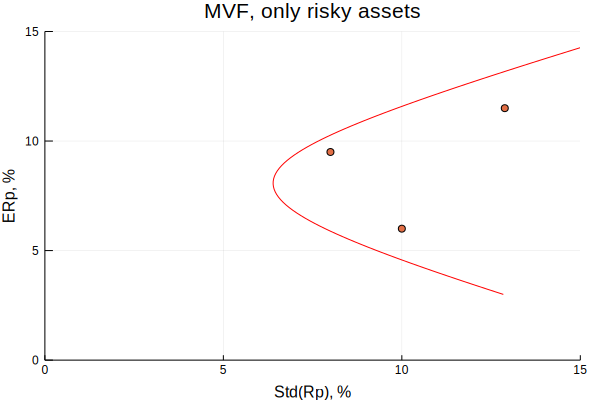

In [19]:
plot3 = plot(StdRp*100,mustar*100,legend=nothing,color=:red,xlim=(0,15),ylim=(0,15))
scatter!(sqrt.(diag(Σ))*100,μ*100)
title!("MVF, only risky assets")
xlabel!("Std(Rp), %")
ylabel!("ERp, %")

In [20]:
StdRpRf  = fill(NaN,L)
for i = 1:L
    StdRpRf[i] = MVCalcRf(mustar[i],μ,Σ,Rf)[1]
end    

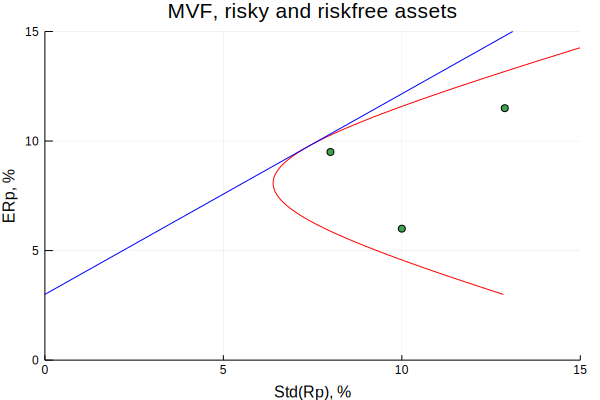

In [21]:
plot4 = plot(StdRp*100,mustar*100,legend=nothing,color=:red,xlim=(0,15),ylim=(0,15))
plot!(StdRpRf*100,mustar*100,legend=nothing,color=:blue)
scatter!(sqrt.(diag(Σ))*100,μ*100)
title!("MVF, risky and riskfree assets")
xlabel!("Std(Rp), %")
ylabel!("ERp, %")

# (extra) Mean-Variance Frontier without Short Selling

The code below solves (numerically) the following minimization problem 

$\min \text{Var}(R_p) \> \text{ s.t. } \>  \text{E}R_p = \mu^*$, and where we require $w_i\ge 0$
 
The code below calls on

`
quadprog(zeros(N),Sigma,A,'=',b,zeros(N),ones(N),IpoptSolver(print_level=1))
`

This means that we minimize
    $0'w + w' \Sigma w/2$ subject to the restrictions $A w = b$ and $0 \leq w \leq 1$. The equality constraints ($A w = b$) are used to impose $1'w=1$ and $\mu'w = \mu^*$ (se the code below).
    
The packages MathProgBase and Ipopt are documented at https://github.com/JuliaOpt/MathProgBase.jl and https://github.com/JuliaOpt/Ipopt.jl.

In [23]:
using MathProgBase, Ipopt

In [24]:
function MeanVarNoSSPs(mu,Sigma,mustar)   #MV with no short-sales, numerical minimization
    (w_p,StdRp) = (NaN,NaN)     #default result (if no feasible solution)        
    N = length(mu)
    if minimum(mu) <= mustar <= maximum(mu)  #try only if feasible
        A   = [ones(1,N);mu']                #1'w=1, mu'w = mustar
        b   = [1;mustar]
        Sol = quadprog(zeros(N),Sigma,A,'=',b,zeros(N),ones(N),IpoptSolver(print_level=1))
        if Sol.status == :Optimal
            w_p = Sol.sol
            StdRp = sqrt(w_p'Sigma*w_p)
        end    
    end    
    return StdRp,w_p
end

MeanVarNoSSPs (generic function with 1 method)

In [25]:
Std_no_ss = fill(NaN,length(mustar))
for i = 1:length(mustar)
    Std_no_ss[i] = MeanVarNoSSPs(μ,Σ,mustar[i])[1]    
end


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



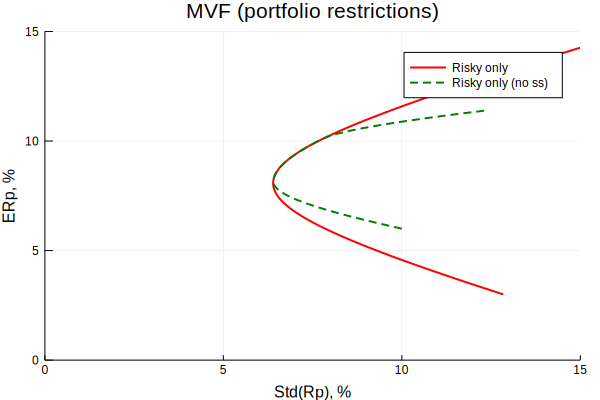

In [26]:
plot(StdRp*100,mustar*100,color=:red,linewidth=2,label="Risky only")
plot!(Std_no_ss*100,mustar*100,color=:green,line=(:dash,2),label="Risky only (no ss) ")
plot!(xlim=(0,15),ylim=(0,15))
title!("MVF (portfolio restrictions)")
xlabel!("Std(Rp), %")
ylabel!("ERp, %")